In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from msresist.figures.common import import_phenotype_data, formatPhenotypesForModeling, plot_AllSites, Introduce_Correct_DDMC_labels
from msresist.figures.figure2 import ComputeCenters, plotStripActualVsPred, create_protein_clustermap, protein_classes, top_prot
from msresist.pre_processing import preprocessing
from msresist.clustering import DDMC
from msresist.plsr import plotStripActualVsPred, plotScoresLoadings
from msresist.figures.figure2 import plotCenters_together

In [2]:
matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(style="whitegrid", font_scale=1.4, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [3]:
lines = ["WT", "KO", "KD", "KI", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F ", "Y821F"]

In [4]:
# Import siganling data
X = preprocessing(AXLm_ErlAF154=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)
d = X.select_dtypes(include=['float64']).T
i = X.select_dtypes(include=['object'])

# Fit DDMC
ddmc = DDMC(i, n_components=5, SeqWeight=2, distance_method="PAM250", random_state=5).fit(d)
centers = ddmc.transform()

# Import phenotypes
cv = import_phenotype_data(phenotype="Cell Viability")
red = import_phenotype_data(phenotype="Cell Death")
sw = import_phenotype_data(phenotype="Migration")
c = import_phenotype_data(phenotype="Island")
y = formatPhenotypesForModeling(cv, red, sw, c)
y = y[y["Treatment"] == "A/E"].drop("Treatment", axis=1).set_index("Lines")

/home/creixell/AXLomics/msresist/pre_processing.py:121: FutureWarning: The provided callable <function mean at 0x7f0c581ae980> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return pd.pivot_table(X, values=values, index=indices, aggfunc=np.mean)
/home/creixell/AXLomics/msresist/pre_processing.py:284: FutureWarning: The provided callable <function mean at 0x7f0c581ae980> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  X = pd.pivot_table(triplicates, values=triplicates[data_headers].columns, index=merging_indices, aggfunc=func_tri)
/home/creixell/AXLomics/msresist/pre_processing.py:284: FutureWarning: The provided callable <function std at 0x7f0c581aeac0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided 

/home/creixell/miniconda3/lib/python3.12/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


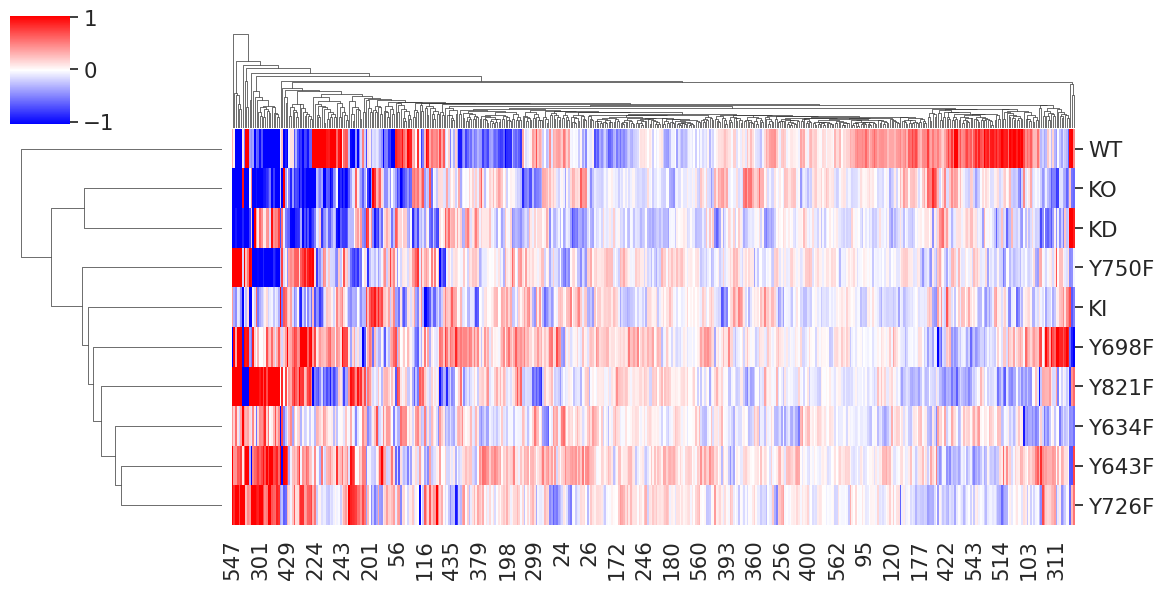

In [5]:
d.index = lines
sns.clustermap(data=d, cmap="bwr", row_cluster=True, col_cluster=True, square=True, robust=True, figsize=(12, 6))

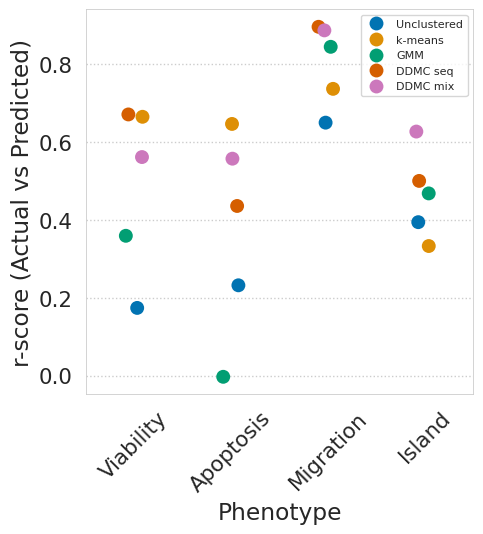

In [6]:
# Predictions
Xs, models = ComputeCenters(X, d, i, ddmc)
Xs.append(centers)
models.append("DDMC mix")

_, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True)
plotStripActualVsPred(ax, [3, 4, 2, 3, 4], Xs, y, models)

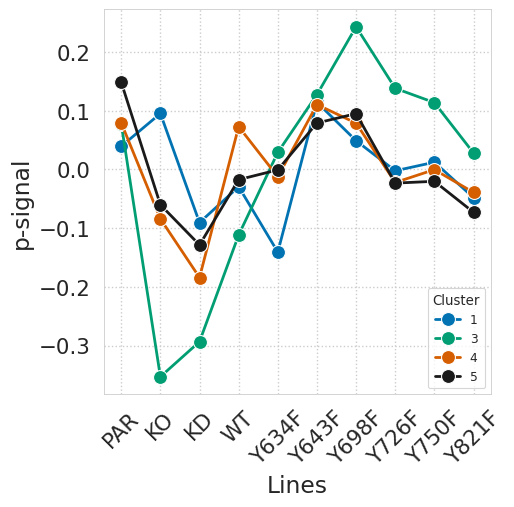

In [7]:
X.columns = X.columns = list(X.iloc[:, :7].columns) + ["PAR", "KO", "KD", "WT", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F", "Y821F"]
_, ax = plt.subplots(1, 1, figsize=(5, 5))
plotCenters_together(ddmc, X, ax, drop=2)

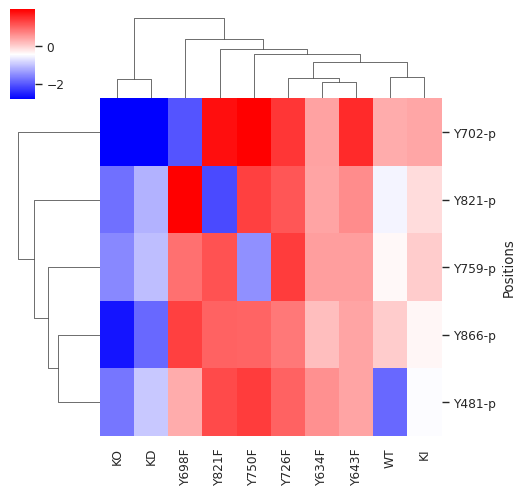

In [8]:
plot_AllSites("", X, "AXL", "AXL", ylim=False, type="Heatmap")

In [9]:
pept_cl = pd.read_csv("/home/creixell/AXLomics/msresist/out/results/Clusters_WTvsKO_pY.csv")
top35_prot = pept_cl.head(40)["Gene"].unique()
X.insert(7, "Cluster", ddmc.labels())
X.set_index("Gene", inplace=True)

In [ ]:
X = Introduce_Correct_DDMC_labels(X, ddmc)

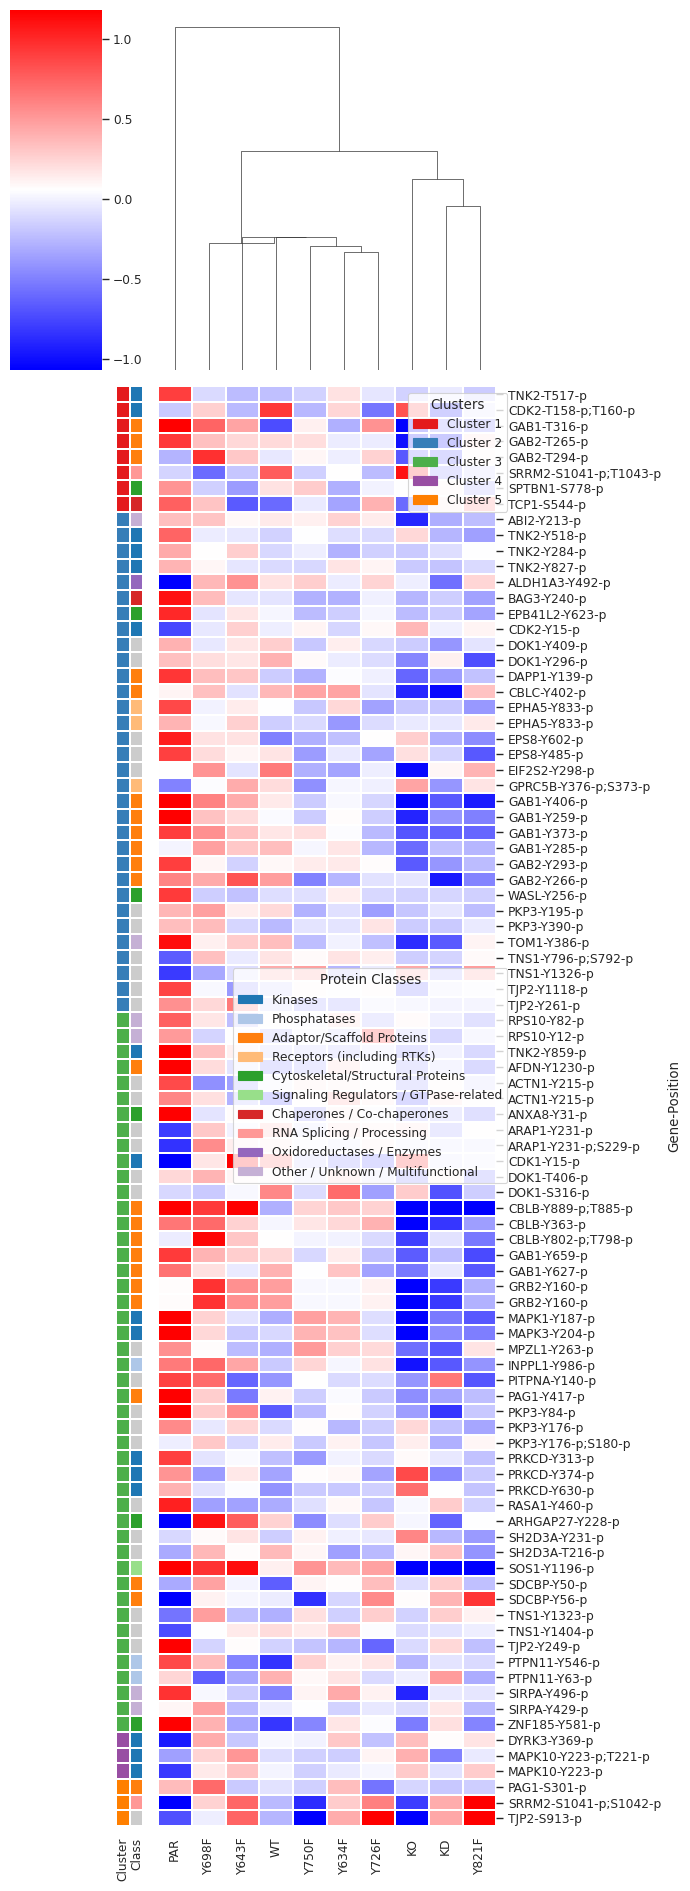

In [11]:
clustermap = create_protein_clustermap(X.loc[top_prot].reset_index().set_index(["Gene", "Position"]), protein_classes)

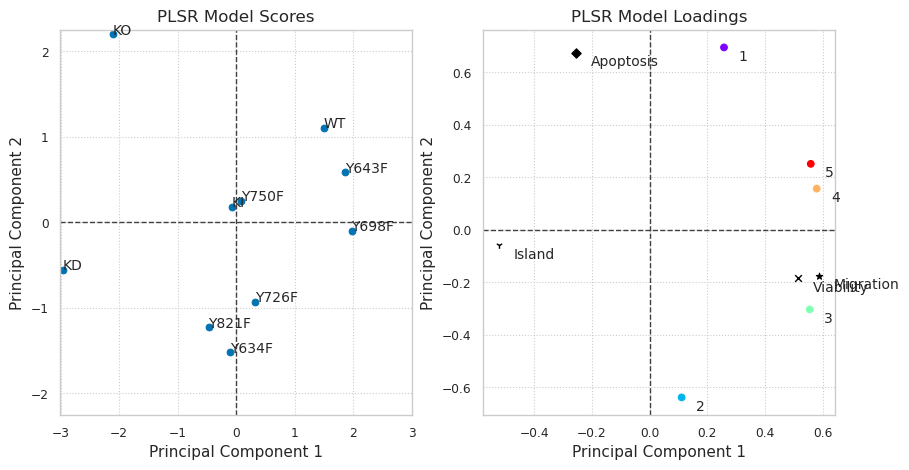

In [12]:
plsr = PLSRegression(n_components=4)

_, ax = plt.subplots(1, 2, figsize=(10, 5))
plotScoresLoadings(ax, plsr.fit(centers, y), centers, y, ddmc.n_components, lines, pcX=1, pcY=2)